## Siamese Neural Networks 
### for Supervised Clustering of High Dimensional Spaces

In [1]:
!python -V
!which python

Python 3.8.5
/Users/seanmacrae/mobius/.venv/bin/python


In [2]:
import pandas as pd

from loaderbot.big_query import query_table_and_cache
from google.cloud import bigquery

sql = """WITH
        investors AS (
        SELECT
            ID AS investorId,
            Level AS investorLevel,
            accredited_income AS accreditedIncome,
            accredited_net_worth AS accreditedNetWorth,
            accredited_entity AS accreditedEntity,
            accredited_license AS accreditedLicense,
            CASE WHEN status = "NULL" THEN NULL ELSE status END AS status
        FROM
        `portal_sync.account_753_dataset_0_file_1141349_Windfall_Data_2021_04_19_csv`
        ),

        investments AS (
        SELECT
            Investor_ID AS investorId,
            SUM(COALESCE(CAST(Amount AS float64), 0)) AS sumAmount,
            MIN(PARSE_TIMESTAMP("%m/%d/%y %H:%M", Investment_Date)) AS minInvestmentDate,
            MAX(PARSE_TIMESTAMP("%m/%d/%y %H:%M", Investment_Date)) AS maxInvestmentDate,
            COUNT(DISTINCT(PARSE_TIMESTAMP("%m/%d/%y %H:%M", Investment_Date))) AS countInvestmentDate,
            SUM(CAST(Closed AS int64)) AS closed
        FROM
        `portal_sync.account_753_dataset_0_file_1140988_Investments_by_Investor_2021_04_19_csv`
        GROUP BY 1
        ),

        matches AS (
            SELECT DISTINCT
                account_id,
                windfall_id ,
                candidate_id,
                confidence
            FROM `portal.match`
            WHERE account_id = 753 
            ),

        leads AS (
            SELECT DISTINCT
            id AS investorId,
            m.windfall_id AS windfall_id,
            PARSE_TIMESTAMP("%Y-%m-%d %H:%M:%S", l.created_at) AS createdAt,
            FROM
            `portal_sync.account_753_dataset_0_file_1251551_mv_windfall_data_2021_05_12_csv` l
            LEFT JOIN matches m ON l.id = m.candidate_id
        ),

      training_data AS (
      SELECT
      CASE
        WHEN (j.sumAmount >= 100000.0 AND investorLevel = "Accredited") THEN "ideal"
        WHEN (a.logNetWorth < 6.0 AND (j.sumAmount = 0.0 OR j.sumAmount IS NULL) AND l.createdAt < PARSE_TIMESTAMP("%Y-%m-%d", "2020-11-01")) THEN "non-ideal"
        ELSE "other" END AS label,
      j.sumAmount AS amount,
      i.investorLevel,
      * EXCEPT(account_id),
      FROM leads l
      LEFT JOIN investors i ON l.investorId = i.investorId
      LEFT JOIN investments j ON l.investorId = j.investorId
      LEFT JOIN matches m ON l.investorId = m.candidate_id
      LEFT JOIN `tranquil-garage-139216.people.audience_latest` a ON a.id = m.windfall_id
      LEFT JOIN people.audience_dbusa_features dbusa using(id)
      WHERE m.candidate_id IS NOT NULL)

    SELECT * FROM training_data
    WHERE label != "other"
    """

df = query_table_and_cache(sql=sql)

/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information 

In [3]:
# import seaborn as sns

# sns.pairplot(los, hue='Stay')

In [4]:
# from sklearn.model_selection import train_test_split

# los_sample, _ = train_test_split(
#     df,
#     test_size=0.98,
#     stratify=los["Stay"])

df.shape

(10186, 149)

## Tabular Learner

Before we train the Tabular Siamese Learner we will train baseline Tabular Learner for species classification... (why do we do this, exactly? can we just instantiate a Tabular Siamese Learner without a baseline Tabular Learner ???)

Ah yes, to init a new `TabularSiameseModel` we need to provide an `encoder` and `head` and the Tabular Learner will act as the `encoder` we init the `TabularSiameseModel` with.

In [5]:
from sklearn.model_selection import train_test_split

# los_train, los_val = train_test_split(
#     los,
#     test_size=0.10,
#     stratify=los["Stay"])

df_train, df_val = train_test_split(
    df,
    test_size=0.10,
    stratify=df["label"])

df.shape, df.shape

exclude_vars = ["label", "id", "investorId", "createdAt", "investorId_1", "investorId_2",
               "investorLevel", "investorLevel_1", "status", "windfall_id", "windfall_id_1",
                "candidate_id", "minInvestmentDate", "maxInvestmentDate", "confidence", 
                "closed", "countInvestmentDate", "amount", "sumAmount"]

In [6]:
from fastai.tabular.all import CategoryBlock
                                
# y_names = ["species"]
y_names = ["label"]
y_block = CategoryBlock()

In [7]:
from mobius.utils import emb_sz_rule

cat_names = [x for x in df.select_dtypes(exclude=['int', 'float']).columns if x != y_names]
cat_names = [x for x in cat_names if x not in exclude_vars]

# calc embedding sizes for each categorical feature
emb_szs = {k: emb_sz_rule(len(df[k].unique())) for k in cat_names}
emb_szs

{}

In [8]:
import numpy as np

cont_names = [x for x in df.select_dtypes([np.number]).columns if x != y_names]
cont_names = [x for x in cont_names if x not in exclude_vars]
cont_names

['accreditedIncome',
 'accreditedNetWorth',
 'accreditedEntity',
 'accreditedLicense',
 'logNetWorth',
 'logAccreditedNetWorth',
 'recentPurchaseDate',
 'recentDivorceDate',
 'recentDeathDate',
 'isBoatOwner',
 'isPlaneOwner',
 'recentPhilanthropicGiftDate',
 'recentFoundationAssociationDate',
 'isFoundationOfficer',
 'recentFoundationTrusteeDate',
 'hasFoundationAssociation',
 'hasCharityBoardMember',
 'hasCharityOfficer',
 'isMultiPropertyOwner',
 'isRentalPropertyOwner',
 'isHouseholdDebt',
 'logTotalHouseholdDebt',
 'recentSecTransactionAcquired',
 'recentSecTransactionDisposed',
 'recentPoliticalContributionDate',
 'isSmallBusinessOwner',
 'isCharityBoardMember',
 'isCharityOfficer',
 'primaryPropertyLoanToValue',
 'logPrimaryPropertyAvm',
 'hasTrust',
 'politicalDemocrat',
 'politicalRepublican',
 'politicalIndependent',
 'femaleCount',
 'maleCount',
 'minHouseholdAge',
 'avgHouseholdAge',
 'maxHouseholdAge',
 'metroNameRank',
 'propertyCount',
 'isSFROwner',
 'isCondoOwner',
 'i

In [9]:
from fastai.tabular.all import (Categorify, CategoryBlock, FillMissing,
                                Normalize, TabDataLoader, TabularPandas,
                                tabular_config, tabular_learner)

procs = [FillMissing, Categorify, Normalize]

In [10]:
from fastai.data.core import range_of
from fastai.tabular.all import RandomSplitter

# train/test split
splits = RandomSplitter(valid_pct=0.10)(range_of(df))

In [11]:
tabular_pandas = TabularPandas(
        df,
        procs=procs,
        cat_names=cat_names,
        cont_names=cont_names,
        y_names=y_names,
        y_block=y_block,
        splits=splits,
        device="cpu")

In [12]:
trn_dl = TabDataLoader(
    tabular_pandas.train,
    bs=128,
    shuffle=True,
    drop_last=True,
    num_workers=4)

val_dl = TabDataLoader(
    tabular_pandas.valid,
    bs=128,
    num_workers=4)

In [13]:
from fastai.data.core import DataLoaders

dls = DataLoaders(trn_dl, val_dl)

print("Sample batch:")
# dls.one_batch()

Sample batch:


In [14]:
from fastai.metrics import F1Score, Precision, Recall, accuracy

# load the tabular_pandas data through the tabular_learner
layers = [2048, 1024, 512]

# tabular learner configuration
config = tabular_config(ps=[0.05, 0.05, 0.05], embed_p=0.03)

learn = tabular_learner(
    dls,
    layers=layers,
    emb_szs=emb_szs,
    config=config,
    metrics=[accuracy,
             Precision(average='macro'),
             Recall(average='macro'),
             F1Score(average='macro')])

In [15]:
learn.fit_one_cycle(n_epoch=1)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.145414,0.799018,0.970530,0.906810,0.801435,0.845185,00:10


In [16]:
# learn.export("tabular_learn.pkl")

In [17]:
from mobius.calibration import ModelWithTemperature

scaled_model = ModelWithTemperature(learn.model)
scaled_model.set_temperature(val_dl)
learn.model = scaled_model.model

Before temperature - NLL: 0.799, ECE: 0.019
Optimal temperature: 1701.985
After temperature - NLL: 0.692, ECE: 0.472


In [18]:
# true species labels
y_true=learn.dls.valid.items["label"]

# model scores and species predictions
y_scores, *_ = learn.get_preds(dl=val_dl)
preds = np.argmax(y_scores, 1).numpy()

In [19]:
print("First 20 investor labels and predictions")
list(zip(y_true, preds))[:10]

First 20 investor labels and predictions


[(0, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (0, 1)]

In [20]:
(y_true == preds).sum() / len(y_true)

0.9705304518664047

## Siamese Net

To init a new `TabularSiameseDataset` object, we only need a `tabular_pandas` object from the fast.ai library.

In [21]:
from mobius.datasets import write_jsonl

# write SNN training data to `data/`
write_jsonl(tabular_pandas.train.to.items[0].items, "data/train_data.jsonl")
write_jsonl(tabular_pandas.valid.to.items[0].items, "data/valid_data.jsonl")

# write SNN training labels to `data/`
tabular_pandas.train.y.to_csv("data/train_labels.csv", index=True)
tabular_pandas.valid.y.to_csv("data/valid_labels.csv", index=True)

In [22]:
from mobius.datasets import TabularSiameseDataset

train_ds = TabularSiameseDataset(
    csv_file="data/train_labels.csv", 
    jsonl_file="data/train_data.jsonl",
    tabular_learner=learn)
    
valid_ds = TabularSiameseDataset(
    csv_file="data/valid_labels.csv", 
    jsonl_file="data/valid_data.jsonl",
    tabular_learner=learn)

In [23]:
train_ds.__len__(), train_ds.__getitem__(1)

(9168,
 ((tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
   tensor([-0.5091, -0.3817,  2.9674,  0.0000,  0.1806, -0.0421, -0.2056, -0.0418,
           -0.0852, -0.0610, -0.0502, -0.2079,  0.0000, -0.0431,  0.0000, -0.0444,
           -0.0362, -0.0234, -0.4137, -0.3311,  0.4361,  0.2865, -0.0209, -0.0234,
           -0.5103, -0.3215, -0.0362, -0.0234, -0.6262,  0.1281, -0.2232, -0.3984,
           -0.3234, -0.0362,  1.1611, -0.3175, -0.8882, -0.3995,  0.3868, -0.5936,
           -0.1487,  0.4127, -0.3273, -0.0845,  0.0611, -0.0091,  0.0402,  0.8051,
            0.0451,  0.9266,  0.9810,  0.8736,  0.1433, -0.0464, -0.1092, -0.2019,
           -0.2389, -0.1593, -0.2653, -0.3071, -0.0313, -0.1272, -0.1082, -0.1049,
           -0.1845, -0.2146, -0.1503, -0.2516, -0.2899, -0.0308, -0.1184, -0.0973,
           -0.0181, -0.5995,  1.6058, -0.4079, -0.0178, -0.5470,  0.3546, -0.3822,
           -0.0179, -0.5525,  0.6106, -0.3792, -0.4867, -0.5140, -0.5134, -0.1991,
    

In [24]:
valid_ds.__len__(), valid_ds.__getitem__(0)

(1018,
 ((tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
   tensor([-5.0909e-01, -3.8172e-01, -3.3700e-01,  0.0000e+00, -4.1761e-01,
           -1.8419e-01, -2.0565e-01, -4.1812e-02, -8.5154e-02, -6.1011e-02,
           -5.0150e-02,  4.8090e+00,  0.0000e+00, -4.3101e-02,  0.0000e+00,
           -4.4353e-02, -3.6202e-02, -2.3360e-02, -4.1374e-01, -3.3115e-01,
            4.3610e-01,  4.9051e-01, -2.0892e-02, -2.3360e-02, -5.1027e-01,
           -3.2153e-01, -3.6202e-02, -2.3360e-02,  9.3476e-01,  5.7179e-02,
           -2.2318e-01, -3.9843e-01, -3.2339e-01, -3.6202e-02, -1.3272e+00,
           -3.1745e-01, -8.1843e-01, -1.5166e+00, -1.7018e+00, -4.3478e-01,
           -1.4868e-01,  4.1265e-01, -3.2728e-01, -8.4501e-02, -9.8262e-02,
           -1.5360e-01,  1.3618e-02,  8.0506e-01,  1.8334e-02, -1.1789e+00,
           -1.1267e+00, -1.1990e+00,  1.4546e+00,  1.0122e+00, -1.0918e-01,
           -2.0188e-01, -2.3890e-01, -1.5934e-01, -2.6534e-01, -3.0707e-01,
     

In [25]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=16, device='cpu', num_workers=2)

Siamese net encoder is the body of the Tabular net we just trained.

In [26]:
dls.dataset.c

2

In [27]:
import copy

encoder = copy.copy(learn)
encoder.model.layers = learn.model.layers[:-1]
encoder_model = encoder.model

In [28]:
from fastai.layers import LinBnDrop

head = LinBnDrop(n_in=layers[-1]*2,
    n_out=64,  # size of output space
    bn=True,
    act=None)

In [29]:
import time
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from fastai.callback.core import Callback

import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# TODO: save every TSNE model as pkl - interactive 3-d w/ tooltip to show point information (id, features, etc.)
class TSNECallback(Callback):
    def after_validate(self):
        plt.clf()
        t = int(time.time())
        train_encoded = list()
        for i in range(len(siamese_learner.dls.valid.dataset.labels)):
            p, _, _ = siamese_learner.dls.valid_ds.__getitem__(i)

            # rehsape into mini-batch size 1
            p = p[0].reshape(1, -1), p[1].reshape(1, -1)

            # encode the household into output embedding space
            p_encode = siamese_learner.model.encode(p)
            train_encoded.append(p_encode)
            
        ids = self.dls.valid.get_idxs()
        y_train_labels = self.dls.valid.dataset.labels["label"]
        train_encoded_df = pd.DataFrame(torch.stack(train_encoded).squeeze())

        # write encoded space to csv
        train_encoded_df.to_csv(f"tsne_{t}_{self.epoch}.csv")
        
        # limit the permutation of hyper-params of t-SNE
        tsne = TSNE(n_components=3, metric="euclidean", n_iter=500)
        encoded_train_tsne = tsne.fit_transform(train_encoded_df.values)
#         np.save(f"tsne_{t}_{self.epoch}.npy", encoded_train_tsne)
        
        xs = encoded_train_tsne[:, 0]
        ys = encoded_train_tsne[:, 1]
        zs = encoded_train_tsne[:, 2]
        
        fig = plt.figure(figsize=(6,6))
        ax = Axes3D(fig) # Method 1
        ax.scatter(xs, ys, zs, c=y_train_labels, marker='o')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.savefig(f"snn_{t}_epoch_{self.epoch}.png")
        
#         # TODO: add title...
#         sns.scatterplot(x=encoded_train_tsne[:,0],
#                         y=encoded_train_tsne[:,1],
#                         hue=y_train_labels, 
#                         legend=False, 
#                         palette="tab10").figure.savefig(f"snn_{t}_epoch_{self.epoch}.png")
        
        
# TODO: run knn on embedding space to show learned embedding is informative!!!

In [30]:
from mobius.models import TabularSiameseModel

model = TabularSiameseModel(encoder_model, head)

In [31]:
from fastai.torch_basics import params
from mobius.losses import ContrastiveLoss

def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

def contrastive_loss_func(out, targ):
    return ContrastiveLoss(margin=0.20)(out, targ.long())

In [32]:
from fastai.learner import Learner

siamese_learner = Learner(dls,
    model,
    model_dir=".",
    loss_func=contrastive_loss_func,
    splitter=siamese_splitter,
    cbs=[TSNECallback])

In [33]:
# y_labels = siamese_learner.dls.valid.dataset.labels["Stay"]
# y_labels.to_csv("y_labels.csv")

In [34]:
# %debug
# siamese_learner.summary()

In [35]:
# siamese_learner.freeze()
# siamese_learner.fit(n_epoch=3, lr=10e-4)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-6a2216b867a1>", line 2, in <module>
    siamese_learner.fit(n_epoch=3, lr=10e-4)
  File "/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/fastai/learner.py", line 205, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/fastai/learner.py", line 154, in _with_events
    try:       self(f'before_{event_type}')       ;f()
  File "/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/fastai/learner.py", line 196, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/fastai/learner.py", line 154, in _with_events
    try:       self(f'before_{event

TypeError: object of type 'NoneType' has no len()

<Figure size 432x288 with 0 Axes>

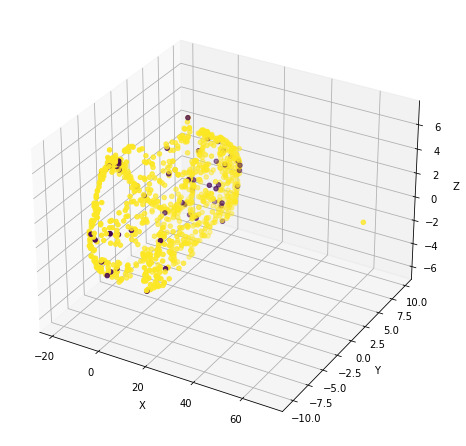

In [36]:
siamese_learner.unfreeze()
siamese_learner.fit(n_epoch=3, lr=10e-4)

In [ ]:
tsne = np.load("tsne_1625777058_0.npy")

In [ ]:
xs = tsne[:, 0]
ys = tsne[:, 1]
zs = tsne[:, 2]

In [ ]:
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig) # Method 1
ax.scatter(xs, ys, zs, marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.savefig("blar")

# # rotate the axes and update
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)
#     plt.show()

In [ ]:
# TODO: inspect margin, using log space grid search - .01, .1, .5, .75, 1., 10., 50. - hypothesis is that the margin is too low and space is collapsging
# TODO: inspect the LR manually - smaller learning rates - maybe fix learning rate across grid search; maybe use lr_min / 2 ?

In [ ]:
siamese_learner.save("snn_margin_20")